In [1]:
import sys
import os
import datetime
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("User Current Version:-", sys.version)

User Current Version:- 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:17) [GCC 12.2.0]


In [2]:
# WOW-NL: Read all hourly aggregations for the desert dust period

path_in_wow = r"/home/jovyan/work/desert_dust_aggregation/{0}"
file_template = r"{0}desert_dust_aggregation_60min.csv"

sta_date = datetime.datetime(2022, 3, 15)
end_date = datetime.datetime(2022, 3, 18)

time_range_days = pd.date_range(start=sta_date, end=end_date, freq="D")

df_60m_temp = pd.DataFrame()
for date in time_range_days:
    cur_file = file_template.format(date.strftime("%Y-%m-%d"))
    cur_path = path_in_wow.format(cur_file)
    df = pd.read_csv(cur_path, sep=",", header=[0, 1], index_col=[0, 1, 2])
    print("Reading: ", cur_path, df.shape)
    df = df["DryBulbTemperature_Celsius"] # Now columns are: ['Latitude', 'Longitude', 'CreatedDateTime', 'mean', 'min', 'max']
    df = df.reset_index(inplace=False)
    df.CreatedDateTime = pd.to_datetime(df.CreatedDateTime, utc=False) # Comment the UTC part for the WOW data of 2019
    df.CreatedDateTime = df.CreatedDateTime.apply(lambda x: x.replace(tzinfo=None))
    df.CreatedDateTime.astype('datetime64[ns]')
    df_60m_temp = pd.concat([df_60m_temp, df], axis=0)  

print(df_60m_temp.head(5))
print()
print(df_60m_temp.tail(5))
print()
print(df_60m_temp.dtypes)
        

Reading:  /home/jovyan/work/desert_dust_aggregation/2022-03-15desert_dust_aggregation_60min.csv (78736, 24)
Reading:  /home/jovyan/work/desert_dust_aggregation/2022-03-16desert_dust_aggregation_60min.csv (78736, 24)
Reading:  /home/jovyan/work/desert_dust_aggregation/2022-03-17desert_dust_aggregation_60min.csv (78736, 24)
Reading:  /home/jovyan/work/desert_dust_aggregation/2022-03-18desert_dust_aggregation_60min.csv (78736, 24)
   Latitude  Longitude     CreatedDateTime      mean  min  max
0   50.6072     4.0565 2022-03-15 00:00:00  7.866667  7.8  7.9
1   50.6072     4.0565 2022-03-15 01:00:00  7.700000  7.6  7.9
2   50.6072     4.0565 2022-03-15 02:00:00  7.200000  6.9  7.5
3   50.6072     4.0565 2022-03-15 03:00:00  7.020000  6.7  7.5
4   50.6072     4.0565 2022-03-15 04:00:00  7.780000  7.7  7.9

       Latitude  Longitude     CreatedDateTime      mean  min  max
78731    55.399       3.81 2022-03-17 20:00:00  8.183333  8.1  8.3
78732    55.399       3.81 2022-03-17 21:00:00  8.06666

In [4]:
# HARMONIE: Read all hourly aggregations for the heatwave period

# import shutup; shutup.please()

def dates_like_this(x):
    try: 
        datefromstr = pd.to_datetime(pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    except ValueError as e: 
        # Patching midnights, because reasons....
        datefromstr = pd.datetime.strptime(x, "%Y-%m-%d")
        datefromstr = pd.to_datetime(datefromstr.replace(minute=0, hour=0, second=1))
    return datefromstr

path_in_harm = r"/home/jovyan/work/Harmonie_values_at_WOW_locations/{0}.csv"

time_range_hours = pd.date_range(start=sta_date, end=end_date, freq="H")[:-1]

df_60m_harm = pd.DataFrame()
for date in time_range_hours:
    date_str = date.strftime("%Y-%m-%d %H:%M")
    cur_path = path_in_harm.format(date_str)
    df = pd.read_csv(cur_path, sep=",", header=0, index_col=0, parse_dates=["datetime"], date_parser=dates_like_this) 
    df_60m_harm = pd.concat([df_60m_harm, df], axis=0)  
    df_60m_harm["t2m_c"] = df_60m_harm["t2m_k"] - 273.15      
    
print(df_60m_harm.head(5))
print()
print(df_60m_harm.tail(5))

/tmp/ipykernel_5566/62632032.py:22: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(cur_path, sep=",", header=0, index_col=0, parse_dates=["datetime"], date_parser=dates_like_this)


AttributeError: module 'pandas' has no attribute 'datetime'

Minimum date:  2022-03-15 00:00:01
Maximum date:  2022-03-15 23:00:00
Minimum date:  2022-03-16 00:00:01
Maximum date:  2022-03-16 23:00:00
Minimum date:  2022-03-17 00:00:01
Maximum date:  2022-03-17 23:00:00


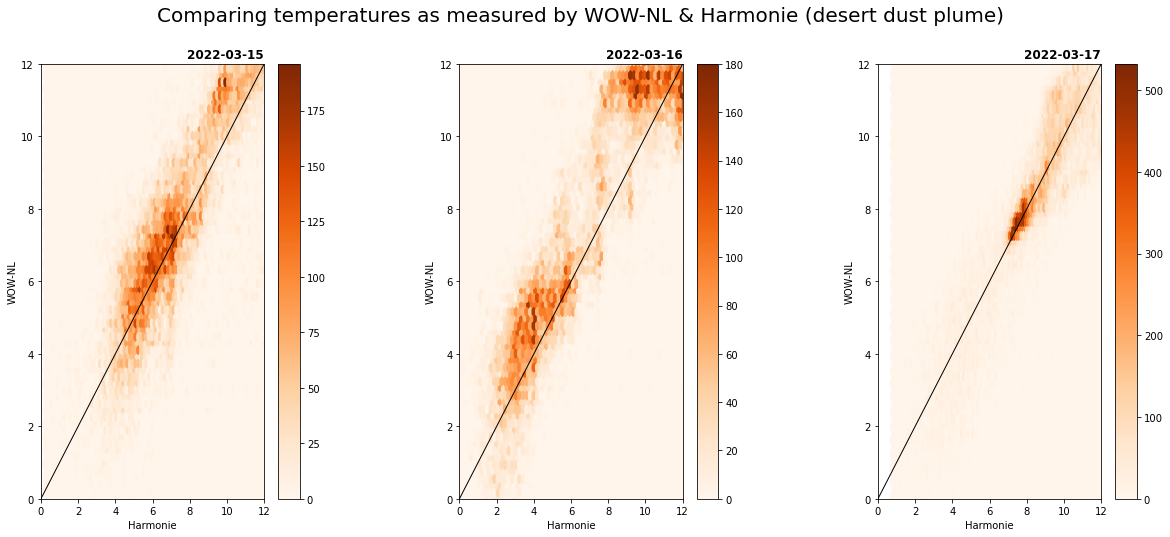

In [15]:
########################################
# DESERT DUST MARCH 2022 2019 USE CASE #
########################################

# (find heatwave use case in the cell above)

# Just in case we recast to 'datetime64[ns]'
df_60m_harm.datetime.astype('datetime64[ns]')
df_60m_temp.CreatedDateTime.astype('datetime64[ns]')

# Merging Harmonie and WOW dataframes, then selecting only the nighttime
# temperatures and grouping per day to create the multiple miniplots
df_merged = pd.merge(df_60m_harm, df_60m_temp, how="left", left_on=["latitude", "longitude", "datetime"], right_on=["Latitude", "Longitude", "CreatedDateTime"])
df_merged = df_merged.set_index(pd.DatetimeIndex(df_merged['datetime']))
df_grouped = df_merged.groupby(pd.Grouper(key="datetime", freq="D"))

  
# Prepare plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
plt.suptitle("Comparing temperatures as measured by WOW-NL & Harmonie (desert dust plume)", size=20)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

i = 0
for name, group in df_grouped:    
    
    print("Minimum date: ", np.amin(group["datetime"]))
    print("Maximum date: ", np.amax(group["datetime"]))
    
    data_wow = group["mean"]
    data_har = group["t2m_c"]    

    ax[i].set_title(str(name).split(" ")[0], loc='right', fontweight="bold")
    bar = ax[i].hexbin(data_har, data_wow, cmap=plt.cm.Oranges)
    ax[i].set_xlim(0, 12)
    ax[i].set_ylim(0, 12)
    ax[i].set_xlabel("Harmonie")
    ax[i].set_ylabel("WOW-NL")
    ax[i].plot([0, 12], [0, 12], 'black', linewidth=1)
    cb = fig.colorbar(bar, ax=ax[i])
    
    i+=1
    
plt.show()

